In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import torch.optim as optim
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [2]:
#Batch size
batch_size=16
#Epoch 
num_epochs=3
#learning rate
learning_rate=0.001

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

train_set=torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=data_transforms['train'])
test_set =torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=data_transforms['val'])

dataloaders=dict()
dataloaders['train']= torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
dataloaders['val']= torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val']}

print("train 개수",dataset_sizes['train'])
print("test 개수",dataset_sizes['val'])

class_names = train_set.classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("class_names:",class_names)
print(device)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
train 개수 50000
test 개수 10000
class_names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
cuda:0


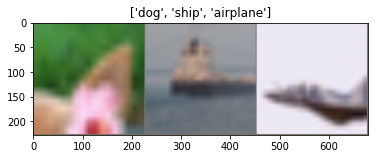

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
#batch가 너무 크면 다 안보이니 3개만 가져오기
inputs_=inputs[:3]
classes_=classes[:3]

# Make a grid from batch
out = torchvision.utils.make_grid(inputs_)

imshow(out, title=[class_names[x] for x in classes_])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_loss_list=[]
    val_acc_list=[]

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            iteration_count=0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                iteration_count+=len(inputs)
                print('Iteration {}/{}'.format(iteration_count,dataset_sizes[phase]))
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase=="train":
              train_loss_list.append(epoch_loss)
            elif phase=="val":
              val_acc_list.append(epoch_acc)


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,train_loss_list,val_acc_list

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [7]:
model_ft = models.densenet161(pretrained=True) #함수 호출, pretrained 사전 학습된 자료 사용 유무
num_ftrs = model_ft.classifier.in_features
model_ft.classifier= nn.Linear(num_ftrs, len(class_names)) #FC layer 새로 생성
model_ft = model_ft.to(device) #모델 로드
print(model_ft)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#SGD
optimizer_ft = optim.SGD(model_ft.parameters(), lr=learning_rate, momentum=0.9)
#Adam
# optimizer_ft = optim.Adam(model_ft.parameters(), lr=learning_rate)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [8]:
model_ft,train_loss_list,val_acc_list = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=num_epochs)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Iteration 40176/50000
Iteration 40192/50000
Iteration 40208/50000
Iteration 40224/50000
Iteration 40240/50000
Iteration 40256/50000
Iteration 40272/50000
Iteration 40288/50000
Iteration 40304/50000
Iteration 40320/50000
Iteration 40336/50000
Iteration 40352/50000
Iteration 40368/50000
Iteration 40384/50000
Iteration 40400/50000
Iteration 40416/50000
Iteration 40432/50000
Iteration 40448/50000
Iteration 40464/50000
Iteration 40480/50000
Iteration 40496/50000
Iteration 40512/50000
Iteration 40528/50000
Iteration 40544/50000
Iteration 40560/50000
Iteration 40576/50000
Iteration 40592/50000
Iteration 40608/50000
Iteration 40624/50000
Iteration 40640/50000
Iteration 40656/50000
Iteration 40672/50000
Iteration 40688/50000
Iteration 40704/50000
Iteration 40720/50000
Iteration 40736/50000
Iteration 40752/50000
Iteration 40768/50000
Iteration 40784/50000
Iteration 40800/50000
Iteration 40816/50000
Iteration 40832/50000
Iteration 40848/50000
Iteration 40864/50

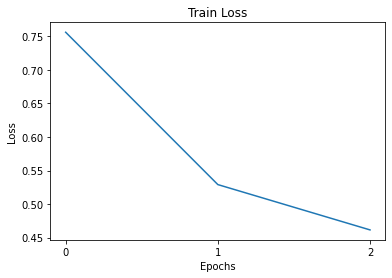

TypeError: ignored

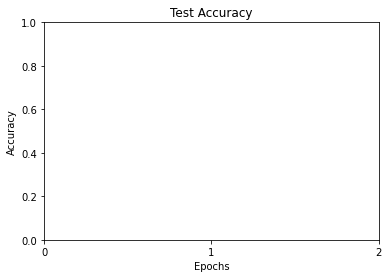

In [10]:
#plot train loss 
x=[i for i in range(0,num_epochs)]
plt.title("Train Loss")
plt.xticks(x)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(x,train_loss_list)
plt.show()

#plot test acc
x=[i for i in range(0,num_epochs)]
plt.title("Test Accuracy")
plt.xticks(x)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(x,val_acc_list)
plt.show()

In [ ]:
visualize_model(model_ft)